# Data import

In [1]:
library(tidyverse)
library(broom)
library(lme4)
library(Hmisc)
library(lattice)
library(ggpubr)
library(effectsize)
library(gridExtra)

options(repr.plot.width=7, repr.plot.height=4)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘broom’ was built under R version 3.6.3”Warning message:
“package ‘lme4’ was built under R version 3.6.3”Loading required package: Matrix

Attaching package:

In [2]:
residuals_plots <- function(model){
    p1 <- ggplot(data = data.frame(residuals = summary(model)$res)) +
        geom_histogram(aes(x = residuals), bins = 25, 
                       fill = "lightblue", color = "black") +
        labs(title = "Histogram of Residuals")

    p2 <- ggplot(data = data.frame(residuals = summary(model)$res), 
           aes(sample = residuals)) +
        stat_qq() + 
        stat_qq_line() +
        labs(title = "QQ Plot of Residuals")
    
    grid.arrange(p1, p2, nrow = 1)
    
    p1 <- plot(model, resid(.) ~ fitted(.), abline=0, main = "All Data")
    p2 <- plot(model, resid(.) ~ fitted(.)|Animal, abline=0, main = "By Animal")
    
    grid.arrange(p1, p2, nrow = 1, widths = c(1.5,2))
}

In [4]:
AVRECPeakCL <- read_csv(file = "../Data/AVRECPeakCLST.csv")

Parsed with column specification:
cols(
  Group = col_character(),
  Animal = col_character(),
  Layer = col_character(),
  Measurement = col_character(),
  ClickFreq = col_double(),
  OrderofClick = col_double(),
  TrialNumber = col_double(),
  PeakAmp = col_double(),
  PeakLat = col_double(),
  RMS = col_double()
)


# Modeling

[**Study design**](https://miro.com/app/board/o9J_lICYkf8=/)

Notes:

* `RMS` variable was log-transformed since the distribution was right-skewed (resulting in a fan shape residuals plots).
* Values in `coef()` function is the actual intercept for an animal. `ranef()` shows the difference from a "main" intercept.


Warning message:
“Removed 116203 rows containing non-finite values (stat_bin).”Warning message:
“Removed 116203 rows containing non-finite values (stat_bin).”

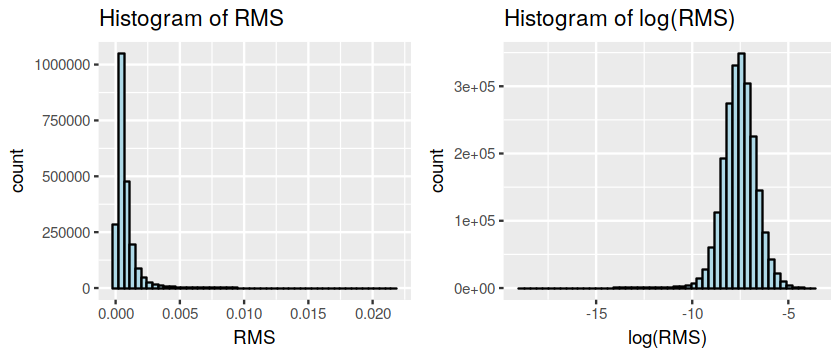

In [7]:
p1 <- ggplot(data = AVRECPeakCL) +
    geom_histogram(aes(x = RMS), bins = 50, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of RMS")

p2 <- ggplot(data = AVRECPeakCL) +
    geom_histogram(aes(x = log(RMS)), bins = 50, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of log(RMS)")

options(repr.plot.width=7, repr.plot.height=3)
grid.arrange(p1, p2, nrow = 1)

## logRMS ~ Group\*Measurement\*Layer + ClickFreq + (...|Animal/TrialNumber)

* Random effect: Animal/TrialNumber
* Fixed effect: Group\*Measurement\*Layer, ClickFreq
* Measurement = ["preAM_1", "AM_1"], [0, 1]
* OrderofClick = 1

In [14]:
temp_df <- AVRECPeakCL %>% 
    filter(
        OrderofClick == 1,
        Layer != "All",
#         RMS < 0.01, # remove outliers?
        Measurement %in% c("preCL_1", "CL_1")) %>%  
    mutate(logRMS = log(RMS),
           MeasurementPost = ifelse(Measurement == "CL_1", 1, 0)) %>% 
    ungroup() %>% 
    drop_na()

temp_df$Measurement <- factor(
    x = temp_df$Measurement, 
    levels = c("preCL_1", "CL_1"))

temp_df$Layer <- factor(x = temp_df$Layer)
# temp_df$ClickFreq <- factor(x = temp_df$ClickFreq)

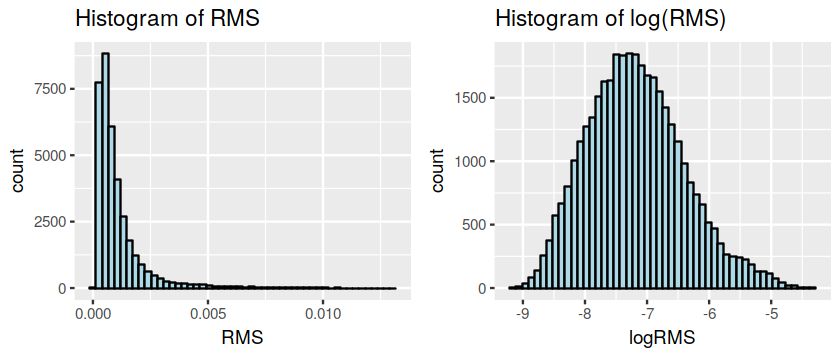

In [15]:
p1 <- ggplot(data = temp_df) +
    geom_histogram(aes(x = RMS), bins = 50, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of RMS")

p2 <- ggplot(data = temp_df) +
    geom_histogram(aes(x = logRMS), bins = 50, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of log(RMS)")

options(repr.plot.width=7, repr.plot.height=3)
grid.arrange(p1, p2, nrow = 1)

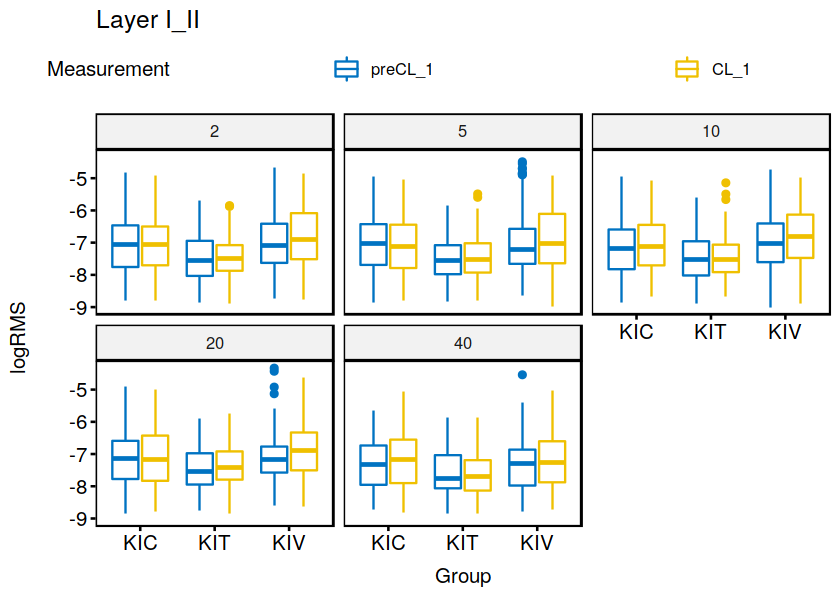

In [16]:
options(repr.plot.width=7, repr.plot.height=5)

temp_df  %>% 
    filter(Layer == "I_II") %>%  # "I_II", "IV", "V", "VI"
ggboxplot(
    x = "Group", y = "logRMS", color = "Measurement", 
    palette = "jco", facet.by = "ClickFreq", main = "Layer I_II" #, add = "jitter",
)

In [17]:
head(temp_df)

Group,Animal,Layer,Measurement,ClickFreq,OrderofClick,TrialNumber,PeakAmp,PeakLat,RMS,logRMS,MeasurementPost
KIC,KIC02,I_II,preCL_1,2,1,1,0.001935411,5,0.001035600,-6.872774,0
KIC,KIC02,I_II,preCL_1,2,1,2,0.002936304,70,0.002773117,-5.887783,0
KIC,KIC02,I_II,preCL_1,2,1,4,0.003400892,70,0.002116366,-6.158055,0
KIC,KIC02,I_II,preCL_1,2,1,5,0.002141539,6,0.001365028,-6.596580,0
KIC,KIC02,I_II,preCL_1,2,1,6,0.001817905,93,0.001306593,-6.640332,0
KIC,KIC02,I_II,preCL_1,2,1,7,0.002389415,79,0.001389709,-6.578661,0


### (1|Animal/TrialNumber); random intercept, fixed slope

We assume that every animal has different "starting point", but the same rate of change (slope).

In [18]:
model0 <- lmer(
    formula = logRMS ~ Group*MeasurementPost*Layer + ClickFreq + 
#         (1|ClickFreq) + 
        (1|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model0)

# ClickFreq/OrderofClick
# control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb'))


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * MeasurementPost * Layer + ClickFreq + (1 | Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 70396.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9811 -0.6627  0.0099  0.6697  3.6372 

Random effects:
 Groups             Name        Variance Std.Dev.
 TrialNumber:Animal (Intercept) 0.005366 0.07325 
 Animal             (Intercept) 0.141394 0.37602 
 Residual                       0.392754 0.62670 
Number of obs: 36618, groups:  TrialNumber:Animal, 1334; Animal, 27

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                      -7.0291808  0.1203802 -58.392
GroupKIT                         -0.2921172  0.1702660  -1.716
GroupKIV                          0.0915400  0.1874082   0.488
MeasurementPost                   0.0427678  0.0228865   1.869
LayerIV                           0.3642143  0.0252207  14.441
LayerV                       

### (Measurement|Animal/TrialNumber); random intercept & slopes

$$logRMS = b^*_0 + b_1 Group + b^*_2 MeasurementPost + b_3 Layer + b_4 Group*MeasurementPost*Layer + b_5 ClickFreq$$ 

$$b^*_0 = b_0 + b^A_0 + b^{A:T}_0$$

$$b^*_2 = b_2 + b^A_2 + b^{A:T}_2$$

In [20]:
model1 <- lmer(
    formula = logRMS ~ Group*MeasurementPost*Layer + ClickFreq + 
#         (1|ClickFreq) + 
        (MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE,
    control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
summary(model1)

Loading required namespace: optimx

Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * MeasurementPost * Layer + ClickFreq + (MeasurementPost |  
    Animal/TrialNumber)
   Data: temp_df
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 69738.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7393 -0.6606  0.0169  0.6783  3.8421 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.004999 0.07071       
                    MeasurementPost 0.014500 0.12041  -0.66
 Animal             (Intercept)     0.130479 0.36122       
                    MeasurementPost 0.035915 0.18951  -0.04
 Residual                           0.383268 0.61909       
Number of obs: 36618, groups:  TrialNumber:Animal, 1334; Animal, 27

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                      -7.0364597  0.1157257 -60.803
GroupKIT               

### (-1 + Measurement|Animal); fixed intercept, random slopes

In [21]:
model2 <- lmer(
    formula = logRMS ~ Group*MeasurementPost*Layer + ClickFreq + 
#         (1|ClickFreq) + 
        (0 + MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model2)


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * MeasurementPost * Layer + ClickFreq + (0 + MeasurementPost |  
    Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 73503.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4411 -0.6650  0.0090  0.6639  4.2264 

Random effects:
 Groups             Name            Variance Std.Dev.
 TrialNumber:Animal MeasurementPost 0.005609 0.07489 
 Animal             MeasurementPost 0.160099 0.40012 
 Residual                           0.429400 0.65529 
Number of obs: 36618, groups:  TrialNumber:Animal, 1334; Animal, 27

Fixed effects:
                                  Estimate Std. Error  t value
(Intercept)                      -7.025520   0.019122 -367.400
GroupKIT                         -0.346581   0.027110  -12.784
GroupKIV                          0.083126   0.028466    2.920
MeasurementPost                   0.030156   0.128790    0.234
LayerIV                           0.368495   0.02634

### Comparison

Akaike information criterion (AIC) - the smaller, the better

$$AIC=2k-2 \mathrm {\ln}(\hat {L})$$

* k = number of estimated parameters in the model
* $\hat{L}$ = maximum value of the likelihood function for the model

In [22]:
AIC(model0) # random intercept & fixed slope

[1] 70452.46

In [23]:
AIC(model1) # random intercept & slope

[1] 69802.89

In [24]:
AIC(model2) # fixed intercept & random slope

[1] 73559.47

How to report your results in paper (from https://www.youtube.com/watch?v=VmPouLbvfXI&t=1999s):

"A linear mixed model was fit with varying intercepts by Animal and Trial and varying correlated slopes by Measurement. The dependent variable was log-transformed. The results show the effect of group was significant $\chi^2 = 207.1$, $p<<0.01$.

## logRMS ~ ... + (Measurement|Animal/TrialNumber)

### Without Group

In [25]:
model3 <- lmer(
    formula = logRMS ~ MeasurementPost*Layer + ClickFreq + 
        (MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE,
    control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
summary(model3)

Linear mixed model fit by REML ['lmerMod']
Formula: logRMS ~ MeasurementPost * Layer + ClickFreq + (MeasurementPost |  
    Animal/TrialNumber)
   Data: temp_df
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 70024.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7770 -0.6582  0.0138  0.6740  3.9322 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.004937 0.07027       
                    MeasurementPost 0.014446 0.12019  -0.66
 Animal             (Intercept)     0.129713 0.36016       
                    MeasurementPost 0.040225 0.20056  0.05 
 Residual                           0.386941 0.62205       
Number of obs: 36618, groups:  TrialNumber:Animal, 1334; Animal, 27

Fixed effects:
                          Estimate Std. Error  t value
(Intercept)             -7.1099143  0.0703135 -101.117
MeasurementPost          0.0529607  0.0411660   

### Without Layer

In [26]:
model4 <- lmer(
    formula = logRMS ~ Group*MeasurementPost + ClickFreq + 
        (MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE,
    control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
summary(model4)

Linear mixed model fit by REML ['lmerMod']
Formula: logRMS ~ Group * MeasurementPost + ClickFreq + (MeasurementPost |  
    Animal/TrialNumber)
   Data: temp_df
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 73942.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2994 -0.6829 -0.0137  0.6583  4.2329 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.002758 0.05252       
                    MeasurementPost 0.009721 0.09859  -0.64
 Animal             (Intercept)     0.132287 0.36371       
                    MeasurementPost 0.035260 0.18778  -0.03
 Residual                           0.433563 0.65845       
Number of obs: 36618, groups:  TrialNumber:Animal, 1334; Animal, 27

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              -7.048569   0.115484 -61.035
GroupKIT                 -0.141256   0.163250  -0.

### Without Measurement

In [27]:
model5 <- lmer(
    formula = logRMS ~ Group*Layer + ClickFreq + 
        (MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model5)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * Layer + ClickFreq + (MeasurementPost | Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 69761.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6820 -0.6625  0.0142  0.6786  3.9741 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.005018 0.07084       
                    MeasurementPost 0.014468 0.12028  -0.66
 Animal             (Intercept)     0.131454 0.36257       
                    MeasurementPost 0.039327 0.19831  -0.06
 Residual                           0.383978 0.61966       
Number of obs: 36618, groups:  TrialNumber:Animal, 1334; Animal, 27

Fixed effects:
                   Estimate Std. Error t value
(Intercept)      -7.0517623  0.1152225 -61.201
GroupKIT         -0.2202862  0.1629089  -1.352
GroupKIV          0.1575635  0.1794204   0.878
LayerIV           0.4252996  0.0153803  27.652
LayerV          

In [28]:
model6 <- lmer(
    formula = logRMS ~ Group*Layer + ClickFreq + 
        (1|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model6)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: logRMS ~ Group * Layer + ClickFreq + (1 | Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 70566.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9910 -0.6643  0.0094  0.6712  3.8057 

Random effects:
 Groups             Name        Variance Std.Dev.
 TrialNumber:Animal (Intercept) 0.005682 0.07538 
 Animal             (Intercept) 0.141610 0.37631 
 Residual                       0.394991 0.62848 
Number of obs: 36618, groups:  TrialNumber:Animal, 1334; Animal, 27

Fixed effects:
                   Estimate Std. Error t value
(Intercept)      -7.0011756  0.1196243 -58.526
GroupKIT         -0.3193127  0.1691264  -1.888
GroupKIV          0.1476662  0.1862863   0.793
LayerIV           0.4189285  0.0155860  26.878
LayerV           -0.0715495  0.0155924  -4.589
LayerVI          -0.3048431  0.0151900 -20.069
ClickFreq        -0.0084174  0.0002621 -32.115
GroupKIT:LayerIV -0.0835728  0.0223504  -3.739
Gro

### Without ClickFreq

In [30]:
model7 <- lmer(
    formula = logRMS ~ Group*MeasurementPost*Layer + (MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE,
    control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
summary(model7)


Correlation matrix not shown by default, as p = 24 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: logRMS ~ Group * MeasurementPost * Layer + (MeasurementPost |  
    Animal/TrialNumber)
   Data: temp_df
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 70775

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5765 -0.6568  0.0230  0.6836  3.7272 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.004248 0.06518       
                    MeasurementPost 0.013042 0.11420  -0.65
 Animal             (Intercept)     0.127045 0.35643       
                    MeasurementPost 0.035843 0.18932  -0.05
 Residual                           0.395125 0.62859       
Number of obs: 36618, groups:  TrialNumber:Animal, 1334; Animal, 27

Fixed effects:
                                 Estimate Std. Error t value
(Intercept)                      -7.15666    0.11420 -62.665
GroupKIT                         -0.28638 

### Comparison

In [31]:
AIC(model1) # full model

[1] 69802.89

In [32]:
AIC(model3) # no Group

[1] 70056.3

In [33]:
AIC(model4) # no Layer

[1] 73970.25

In [34]:
AIC(model5) # no Measurement in fixed effectes

[1] 69801.82

In [35]:
AIC(model6) # no Measurement in fixed & random effectes

[1] 70598.71

In [36]:
AIC(model7) # no ClickFreq

[1] 70836.95

# Final Model

In [37]:
summary(model1)$call

lmer(formula = logRMS ~ Group * MeasurementPost * Layer + ClickFreq + 
    (MeasurementPost | Animal/TrialNumber), data = temp_df, REML = TRUE, 
    control = lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb")))

## Diagnostic

$`TrialNumber:Animal`

$Animal


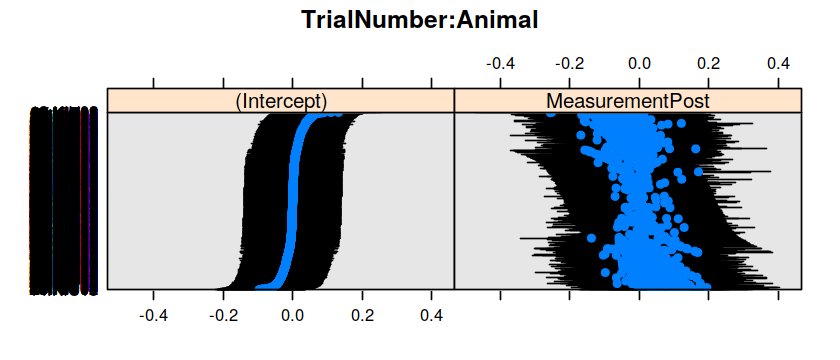

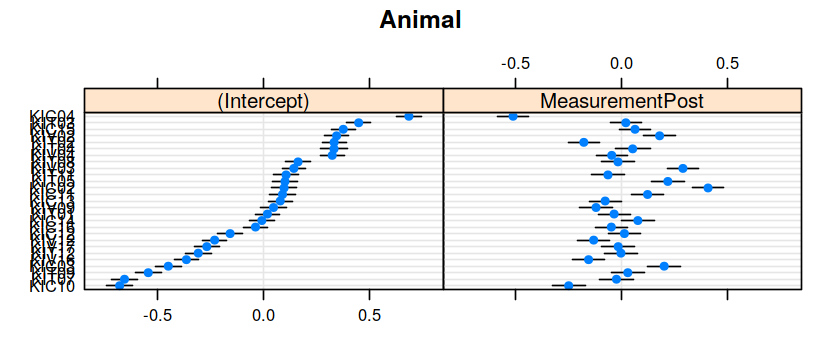

In [38]:
options(repr.plot.width=7, repr.plot.height=3)
dotplot(ranef(model1, condVar = TRUE))

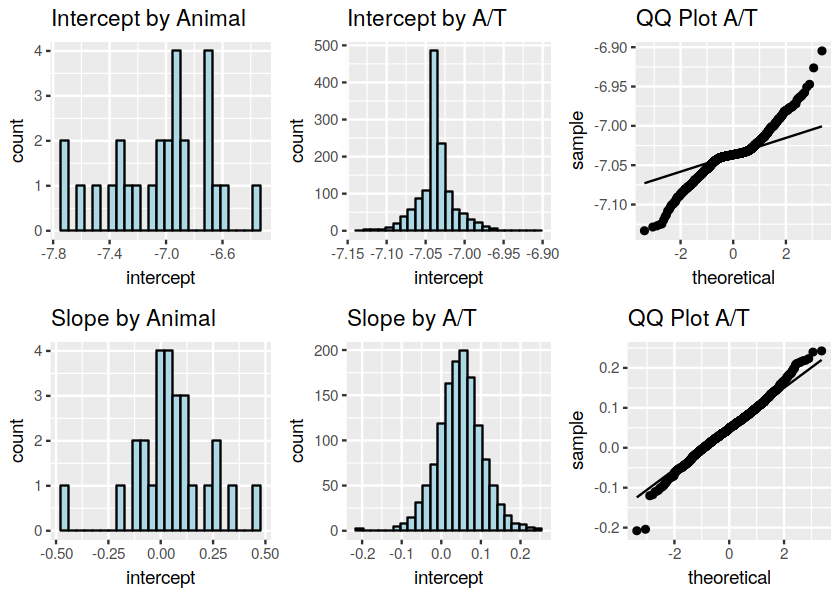

In [49]:
p1 <- ggplot(data = data.frame(intercept = coef(model1)$Animal$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal")

p2 <- ggplot(data = data.frame(intercept = coef(model1)$`TrialNumber:Animal`$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by A/T")

p3 <- ggplot(data = data.frame(intercept = coef(model1)$`TrialNumber:Animal`$`(Intercept)`), 
           aes(sample = intercept)) +
        stat_qq() + 
        stat_qq_line() +
        labs(title = "QQ Plot A/T")

p4 <- ggplot(data = data.frame(intercept = coef(model1)$Animal$MeasurementPost)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by Animal")

p5 <- ggplot(data = data.frame(intercept = coef(model1)$`TrialNumber:Animal`$MeasurementPost)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by A/T")

p6 <- ggplot(data = data.frame(intercept = coef(model1)$`TrialNumber:Animal`$MeasurementPost), 
           aes(sample = intercept)) +
        stat_qq() + 
        stat_qq_line() +
        labs(title = "QQ Plot A/T")

options(repr.plot.width=7, repr.plot.height=5)
grid.arrange(p1, p2, p3, p4, p5, p6, nrow = 2)

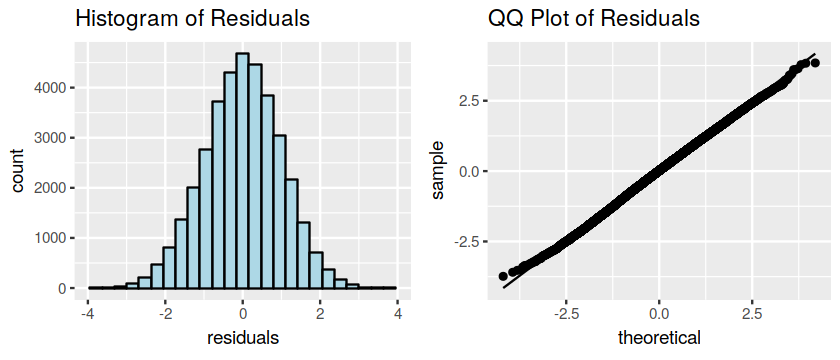

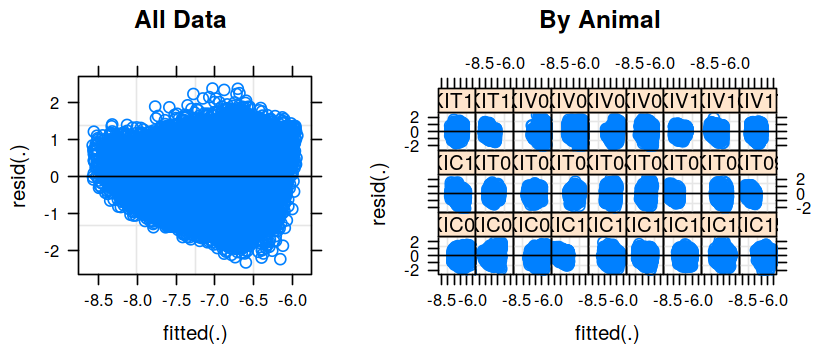

In [40]:
options(repr.plot.width=7, repr.plot.height=3)
residuals_plots(model = model1)

## Interpretation

In [41]:
summary(model1)


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * MeasurementPost * Layer + ClickFreq + (MeasurementPost |  
    Animal/TrialNumber)
   Data: temp_df
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 69738.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7393 -0.6606  0.0169  0.6783  3.8421 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.004999 0.07071       
                    MeasurementPost 0.014500 0.12041  -0.66
 Animal             (Intercept)     0.130479 0.36122       
                    MeasurementPost 0.035915 0.18951  -0.04
 Residual                           0.383268 0.61909       
Number of obs: 36618, groups:  TrialNumber:Animal, 1334; Animal, 27

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                      -7.0364597  0.1157257 -60.803
GroupKIT               

* Intercept: Group `KIC`, Layer `I_II`, pre Measurement, -0.0040315 * `ClickFreq`
* with increase of `ClickFreq` by 1, `RMS` changes by ~0.996

For Layer `I_II` (constant `ClickFreq`):

* Group `KIT`: RMS changes by ≈1.011 after the signal ⬆️;
* Group `KIV`: RMS changes by ≈1.138 after the signal ⬆️;
* Group `KIC`: RMS changes by ≈1.049 after the signal ⬆️;

For Layer `IV` (constant `ClickFreq`):

* Group `KIT`: RMS changes by ≈0.808 after the signal ⬇️;
* Group `KIV`: RMS changes by ≈1.023 after the signal ⬆️;
* Group `KIC`: RMS changes by ≈1.136 after the signal ⬆️;

For Layer `V` (constant `ClickFreq`):

* Group `KIT`: RMS changes by ≈0.917 after the signal ⬇️;
* Group `KIV`: RMS changes by ≈1.140 after the signal ⬆️;
* Group `KIC`: RMS changes by ≈1.119 after the signal ⬆️;

For Layer `VI` (constant `ClickFreq`):

* Group `KIT`: RMS changes by ≈0.945 after the signal ⬇️;
* Group `KIV`: RMS changes by ≈1.027 after the signal ⬆️;
* Group `KIC`: RMS changes by ≈1.080 after the signal ⬆️.

In [71]:
l = "VI"
g = "KIC"
cf = 1

pre = predict(
    object = model1, 
    re.form = NA, # set random effects to zero
    newdata = data.frame(
        Group = g, 
        MeasurementPost = 0,
        Layer = l,
        ClickFreq = cf))

post = predict(
    object = model1, 
    re.form = NA, # set random effects to zero
    newdata = data.frame(
        Group = g, 
        MeasurementPost = 1,
        Layer = l,
        ClickFreq = cf))

print(paste(pre, post))
print(paste(exp(pre), exp(post)))
print(round(exp(post) / exp(pre),3))

[1] "-7.36378174135136 -7.28658029025255"
[1] "0.000633797065104688 0.000684665410914752"
   1 
1.08 


In [51]:
anova(model1, model3) # full vs w/o Group

refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
model3,16,69991.22,70127.35,-34979.61,69959.22,NA,NA,NA
model1,32,69662.85,69935.11,-34799.42,69598.85,360.3705,16,7.099999e-67


In [52]:
anova(model1, model4) # full vs w/o Layer

refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
model4,14,73937.30,74056.42,-36954.65,73909.30,NA,NA,NA
model1,32,69662.85,69935.11,-34799.42,69598.85,4310.451,18,0


In [53]:
anova(model1, model5) # full vs w/o Measurement in fixed

refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
model5,20,69719.86,69890.02,-34839.93,69679.86,NA,NA,NA
model1,32,69662.85,69935.11,-34799.42,69598.85,81.00947,12,2.648287e-12


In [54]:
anova(model1, model6) # full vs w/o Measurement in fixed & random

refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
model6,16,70517.25,70653.38,-35242.62,70485.25,NA,NA,NA
model1,32,69662.85,69935.11,-34799.42,69598.85,886.4015,16,2.244095e-178


In [55]:
anova(model1, model7) # full vs w/o ClickFreq

refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
model7,31,70712.06,70975.81,-35325.03,70650.06,NA,NA,NA
model1,32,69662.85,69935.11,-34799.42,69598.85,1051.207,1,1.330411e-230
